In [1]:
import numpy as np
from datasets import load_from_disk
import sys
sys.path.append('../')
import os
os.environ["HF_DATASETS_CACHE"]="/shared/.cache/huggingface/dataset"

In [2]:
datasets = load_from_disk('/shared/how2_all_proc') #Just filtered Velocity

In [3]:
from utils.dataset import setup_data
datasets = setup_data('/shared/how2_all_proc', ds_frac=0.1)

Loading cached split indices for dataset at /shared/how2_all_proc/cache-de358b2c5fbf8361.arrow and /shared/how2_all_proc/cache-0dcb19661ebabc7e.arrow


In [1]:
output_dirs:{
    'z90':'training_output_05_15_30_01_2024',
    'm90':'training_output_01_09_30_01_2024',
    'm90-2': 'training_output_05_40_30_01_2024_1',
    'z50':'training_output_05_26_30_01_2024',
    'm50':'training_output_05_34_30_01_2024',
    'm50-2': 'training_output_07_10_30_01_2024',
    'z30':'training_output_16_13_30_01_2024',
    'm30': 'training_output_16_04_30_01_2024',
    'z10':'training_output_16_22_30_01_2024_2',
    'm10':'training_output_16_19_30_01_2024'
}

In [212]:
from safetensors.torch import load_model
from model import MFDOOM
from encoders import MultimodalCollator
from torch.utils.data import DataLoader
from utils.config import training_config, get_model_config
output_dir = "/efs-private/multimodal/training_output_01_35_20_01_2024" #0.8 Doom
#output_dir = "/efs-private/multimodal/training_output_01_36_20_01_2024" #0.3 Doom
#output_dir = "/efs-private/multimodal/training_output_01_38_20_01_2024" #0.8 Zorro
#output_dir = "/efs-private/multimodal/training_output_01_37_20_01_2024" #0.3 Zorro
config = training_config(os.path.join(output_dir,'config.yaml'))
model_config = get_model_config(config)
model_config['batch_size']=4

batch_size: 8
clip: 2.0
dataset: /shared/how2_all_proc
dim_head: 64
dropout: 0.1
ds_frac: 0.2
ds_seed: 42
encoder_configs:
  aud:
    max_tokens: 320
    patch_size: [32, 8]
    type: PatchEncoder
  en:
    max_tokens: 64
    num_embeddings: 8192
    type: SequenceEncoder
  pt:
    max_tokens: 64
    num_embeddings: 8192
    type: SequenceEncoder
  sm:
    max_tokens: 64
    num_embeddings: 8192
    type: SequenceEncoder
  vid:
    max_tokens: 2048
    num_embeddings: 2048
    padding_idx: -1
    type: TabularEncoder
epochs: 64
ff_mult: 4
heads: 8
hidden_size: 512
inverse_doom: True
isolate_fusion_tokens: True
layers: 4
lr: 1e-05
lr_scheduler_type: constant_with_warmup
modality_config:
  aud:
    dropout: 0.8
    max_channels: 40
    pad_len: 2048
    padding:
      values: -10000
    type: matrix
  en:
    data_col_name: tokens
    dropout: 0.8
    pad_len: 64
    padding:
      attention_mask: 1
      tokens: 0
    type: sequence
  pt:
    data_col_name: tokens
    dropout: 0.8
    p

In [213]:
import model
from importlib import reload
reload(model)
from model import MFDOOM

In [214]:
default_data_collator = MultimodalCollator(config.modality_config)
#dataloader2 = DataLoader(dataset.with_format('torch'), shuffle=True, collate_fn=default_data_collator, batch_size=4,)
dataloader = DataLoader(datasets['test'].with_format('torch'), 
                        shuffle=True, 
                        collate_fn=default_data_collator, 
                        batch_size=4,)

In [215]:
import torch
model = MFDOOM(**model_config)

Got kwargs: {}
Doing MSE


In [216]:
import torch
from safetensors.torch import load_model
load_model(model,os.path.join(output_dir,'model.safetensors'))

(set(), [])

In [217]:
dl=iter(dataloader)
infer_model = model.eval()
#batch = [next(dl) for x in range(4)]
output = [infer_model(next(dl)) for _ in range(2)]

In [218]:
def zero_modes(batch, modes_to_zero):
    for mode in modes_to_zero:
        print(mode)
        if mode == 'aud':
            batch[mode]['values'] = torch.ones_like(batch[mode]['values'])*-10000
        elif mode == 'vid':
            batch[mode]['attention_mask']=torch.ones_like(batch[mode]['attention_mask'])
        else:
            batch[mode]['attention_mask']=torch.ones_like(batch[mode]['attention_mask'])
    return batch

In [219]:
from tqdm import tqdm
from collections import defaultdict
import copy
import random
output=defaultdict(list)
infer_model = model.eval()
dl = iter(dataloader)
#mode_sets = [('aud',),('sm',),('en',),('pt',),('vid',)]
mode_sets = [('aud','sm',), ('vid','aud',), ('sm','en','pt',)]
batches = []
with torch.no_grad():
    for i in tqdm(range(4)):
        batch = next(dl)
        batches.append(batch)
        #batch = {k: {k2: v2 for k2,v2 in v.items()} for k,v in batch.items()}
        output[('baseline',)].append(infer_model(batch))
        random.shuffle(mode_sets)
        for modes in mode_sets:
            mode_batch = copy.deepcopy(batch)
            output[modes].append(infer_model(zero_modes(mode_batch,modes)))
print(output)

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

vid
aud
aud
sm
sm
en
pt


 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:13<00:39, 13.04s/it]

aud
sm
vid
aud
sm
en
pt


 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [00:25<00:25, 12.95s/it]

vid
aud
aud
sm
sm
en
pt


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [00:38<00:12, 12.91s/it]

vid
aud
sm
en
pt
aud
sm


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:52<00:00, 13.02s/it]

defaultdict(<class 'list'>, {('baseline',): [{'aud': tensor([[-0.0569,  0.1712, -0.0178,  ...,  0.0418,  0.0854, -0.3830],
        [-0.0673,  0.1987, -0.0901,  ..., -0.0346,  0.0054, -0.4742],
        [ 0.0397,  0.1599,  0.0063,  ..., -0.0439,  0.0608, -0.4227],
        [ 0.0361,  0.1591, -0.0578,  ..., -0.0079,  0.0162, -0.3949]]), 'en': tensor([[-0.0965,  0.1151,  0.0180,  ..., -0.0110,  0.0658, -0.3375],
        [-0.0749,  0.2459,  0.0046,  ...,  0.0232,  0.1249, -0.3584],
        [-0.0599,  0.1697, -0.0653,  ...,  0.0173,  0.0581, -0.3761],
        [-0.0965,  0.2729,  0.0164,  ...,  0.0697,  0.1110, -0.3284]]), 'pt': tensor([[-0.1107,  0.2294, -0.0105,  ..., -0.0225,  0.0817, -0.3266],
        [-0.0252,  0.1865, -0.0210,  ..., -0.0137,  0.1390, -0.3588],
        [-0.0616,  0.1910, -0.0297,  ...,  0.0198,  0.0772, -0.3976],
        [-0.0791,  0.2997, -0.0285,  ...,  0.0484,  0.1672, -0.3068]]), 'sm': tensor([[-0.0464,  0.1917,  0.0258,  ..., -0.0705,  0.0534, -0.3883],
        [-0.0

In [220]:
def refactor(outputs):
    out_dict = {k:[] for k in outputs[0]}
    for k in ["losses", "loss", "modality_sample_mask"]:
        out_dict.pop(k, None)
    for batch in outputs:
        for key in out_dict.keys():
            out_dict[key].append(batch[key])
    print(out_dict.keys())
    out_dict = {k:torch.cat(v) for k,v in out_dict.items()}
    return out_dict

In [221]:
output_r = {k: refactor(v) for k,v in output.items()}

dict_keys(['aud', 'en', 'pt', 'sm', 'vid', 'fusion', 'fusion_aud', 'fusion_en', 'fusion_pt', 'fusion_sm', 'fusion_vid', 'global_output'])
dict_keys(['aud', 'en', 'pt', 'sm', 'vid', 'fusion', 'fusion_aud', 'fusion_en', 'fusion_pt', 'fusion_sm', 'fusion_vid', 'global_output'])
dict_keys(['aud', 'en', 'pt', 'sm', 'vid', 'fusion', 'fusion_aud', 'fusion_en', 'fusion_pt', 'fusion_sm', 'fusion_vid', 'global_output'])
dict_keys(['aud', 'en', 'pt', 'sm', 'vid', 'fusion', 'fusion_aud', 'fusion_en', 'fusion_pt', 'fusion_sm', 'fusion_vid', 'global_output'])


In [222]:
output[('baseline',)][0]['aud']

tensor([[-0.0569,  0.1712, -0.0178,  ...,  0.0418,  0.0854, -0.3830],
        [-0.0673,  0.1987, -0.0901,  ..., -0.0346,  0.0054, -0.4742],
        [ 0.0397,  0.1599,  0.0063,  ..., -0.0439,  0.0608, -0.4227],
        [ 0.0361,  0.1591, -0.0578,  ..., -0.0079,  0.0162, -0.3949]])

In [223]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cosines(output, output2=None, log=False, vmin=None, vmax=None, plot_diag=True):
    cos = torch.nn.CosineSimilarity(dim=0)
    mat_dict={}
    for k,v in output.items():
        l = v.shape[0]
        mat_dict[k]=np.zeros([l,l])
        v2 = output2[k] if output2 else output['fusion']
        for i in range(l):
            for j in range(l):
                #print(f"{i},{j},{cos(output.fusion[i],output.fusion[j])}")
                if log:
                    mat_dict[k][i,j]=np.log10(cos(v[i],v2[j]))
                else:
                    mat_dict[k][i,j]=cos(v[i],v2[j])

    f, ax = plt.subplots(len(mat_dict),2, figsize=(6,3*len(mat_dict)))
    for i,(k,mat) in enumerate(mat_dict.items()):
        #f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2))
        #plt.figure(figsize=(2,2))
        #ax1.title(k)
        ax1 = ax[i,0]
        im = ax1.imshow(mat, vmin=vmin, vmax=vmax)
        ax1.set_ylabel(k)
        f.colorbar(im,ax=ax1)
        if plot_diag:
            #plt.figure(figsize=(2,2))
            #plt.title(f"{k} diagonals")
            bins = np.linspace(0,1.0,100)
            ax2 = ax[i,1]
            ax2.hist(np.diagonal(mat), bins=bins, alpha=0.3,density=True)
            ax2.hist(mat.flatten(), bins=bins, alpha=0.3, density=True)
            ax2.set_ylim(0,50)
            ax2.set_xlim(0,1.0)
            ax2.annotate(str(np.mean((mat.sum(1)-np.diag(mat))/(mat.shape[1]-1))),
                        [0.1, 0.1])
            ax2.legend(["diag","all"])

        

In [224]:
print(output_r.keys())

dict_keys([('baseline',), ('vid', 'aud'), ('aud', 'sm'), ('sm', 'en', 'pt')])


('vid', 'aud')


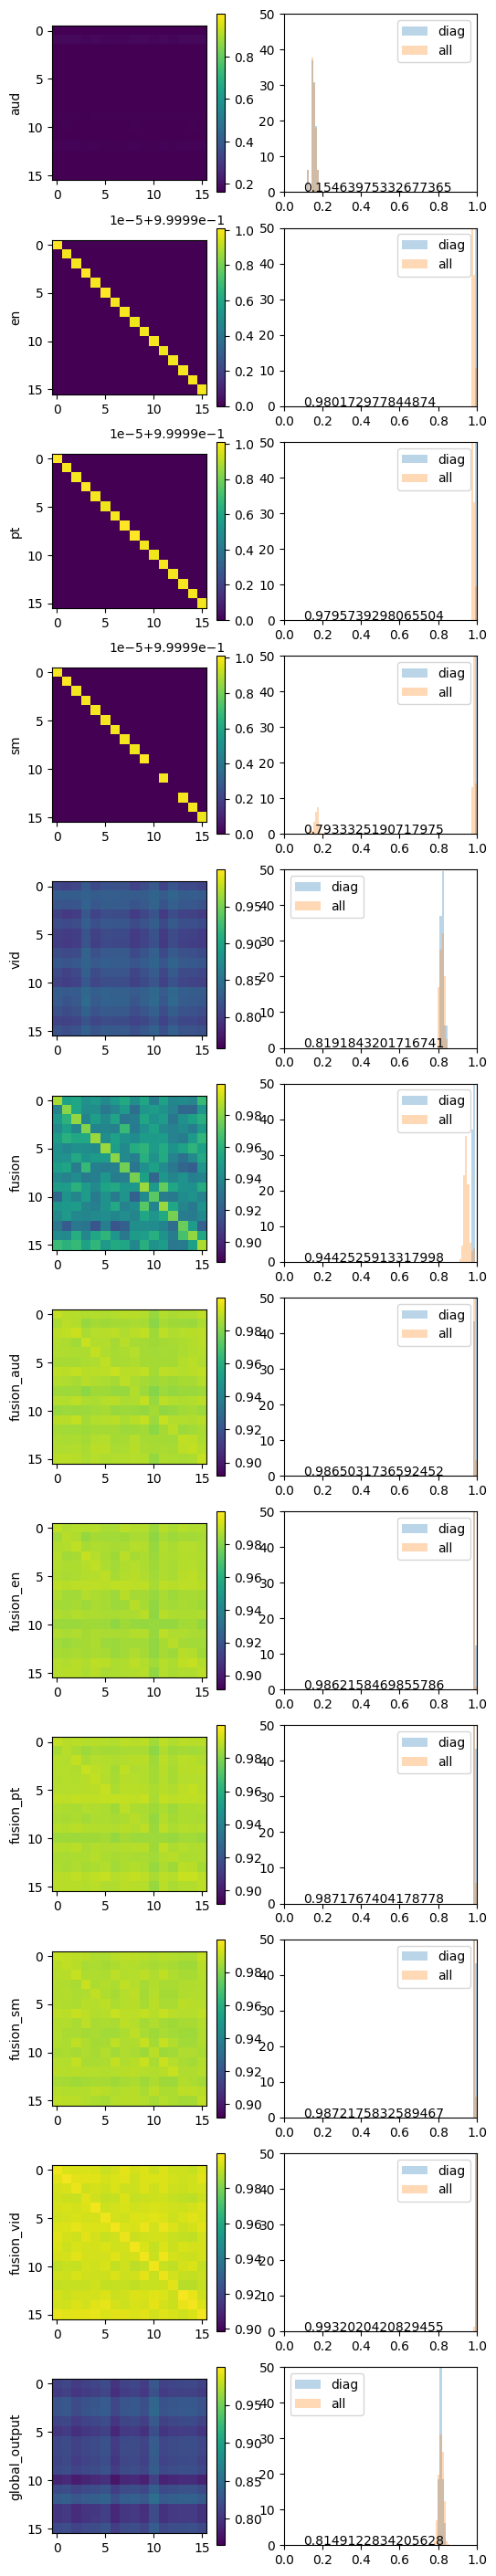

In [225]:
k = mode_sets[0]
print(k)
plot_cosines(output_r[('baseline',)],output_r[k],vmin=0.99999) #

# Attention masking tests

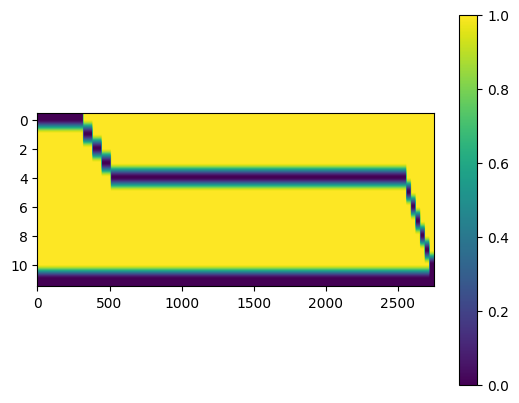

In [171]:
plt.imshow(model.pool_mask, aspect=100)
plt.colorbar()

In [237]:
t=torch.load('../batch.pt', map_location=torch.device('cpu'))
p=torch.load('../padding_mask.pt', map_location=torch.device('cpu'))
a = torch.load('../attn_mask.pt', map_location=torch.device('cpu'))

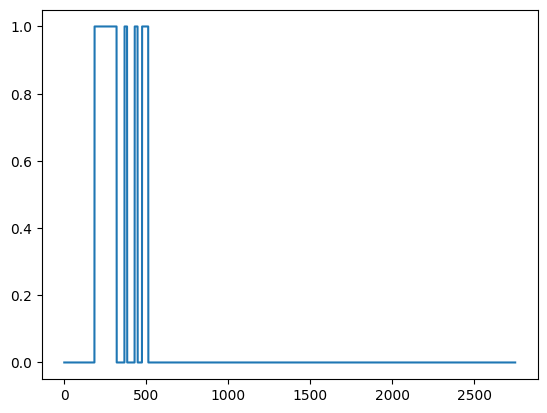

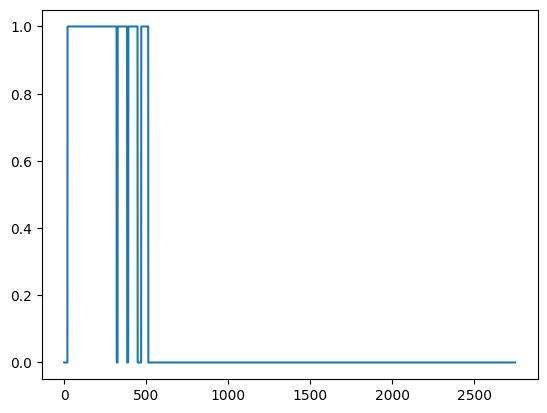

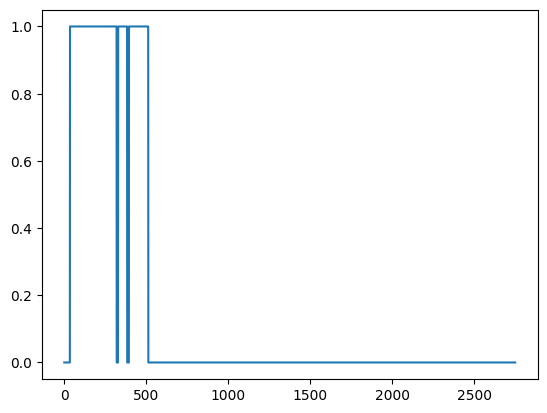

In [238]:
plt.plot(p[0,:])
plt.figure()
plt.plot(p[1,:])
plt.figure()
plt.plot(p[4,:])

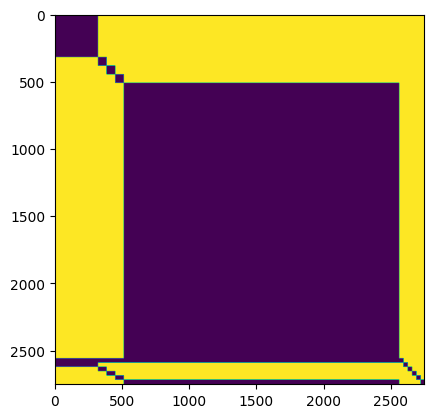

In [239]:
plt.imshow(a)

torch.Size([8, 1409024])


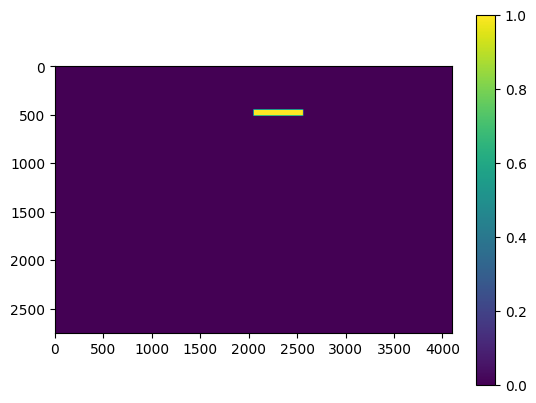

In [234]:
print(t.isnan().reshape((-1,t.shape[1]*t.shape[2]))
      .shape)
plt.imshow(torch.cat([t.isnan()[i,:,:] for i in range(8)], dim=1))
plt.colorbar()

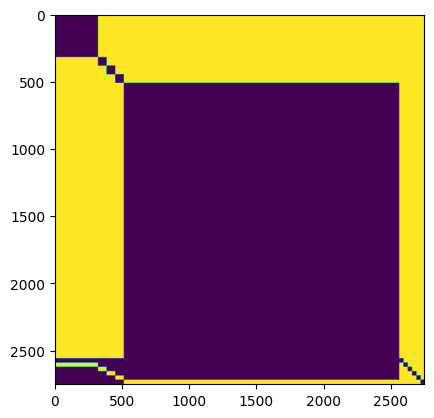

In [158]:
plt.imshow(model.attn_mask)

In [116]:
import torch
token_types = torch.tensor(list((
    *((0,) * 1024),
    *((1,) * 1024),
    *((2,) * 1024),
    *((3,) * 1024),
)), dtype=torch.long)

In [117]:
token_types.shape

torch.Size([4096])

In [118]:
from einops import rearrange, repeat

In [119]:
token_types_attend_from = rearrange(token_types, 'i -> i 1')
token_types_attend_to = rearrange(token_types, 'j -> 1 j')

In [120]:
zorro_mask = token_types_attend_from == token_types_attend_to

In [121]:
zorro_mask = zorro_mask | (token_types_attend_from == 3)

0
-1024:-769
1
-768:-513
2
-512:-257
3
-256:-1


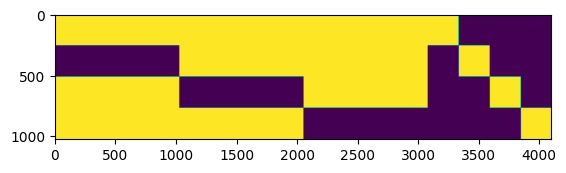

In [189]:
token_types
floom_mask = [token_types != i for i in range(-1,3)]
for idx, tokens in enumerate(floom_mask):
    print(idx)
    a = -256*4 + 256*idx
    b = -256*4 + 256*(idx+1)-1
    print(f"{a}:{b}")
    tokens[-256*4:] = False
    tokens[a:b]= True
floom_mask = repeat(floom_mask, 'i j -> (i i2) j', i2=256)
plt.imshow(floom_mask)#, aspect = 1000)

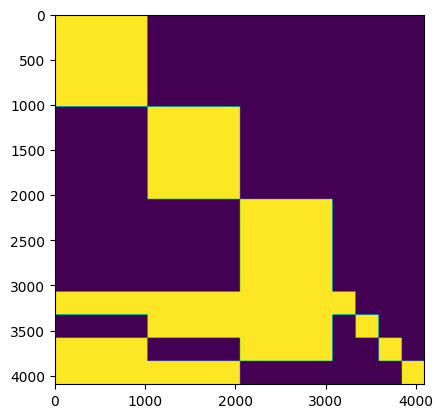

In [190]:
import matplotlib.pyplot as plt
zorro_mask[token_types == 3] = floom_mask
plt.imshow(zorro_mask)

/tmp/ipykernel_914643/776592073.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


[Text(0, -500.0, '0'),
 Text(0, 0.0, 'Modality 1'),
 Text(0, 500.0, 'Modality 2'),
 Text(0, 1000.0, 'Modality 3'),
 Text(0, 1500.0, 'Fusion -1'),
 Text(0, 2000.0, 'Fusion 0'),
 Text(0, 2500.0, 'Fusion 1'),
 Text(0, 3000.0, 'Fusion 2'),
 Text(0, 3500.0, 'Global Tokens'),
 Text(0, 4000.0, ''),
 Text(0, 4500.0, '')]

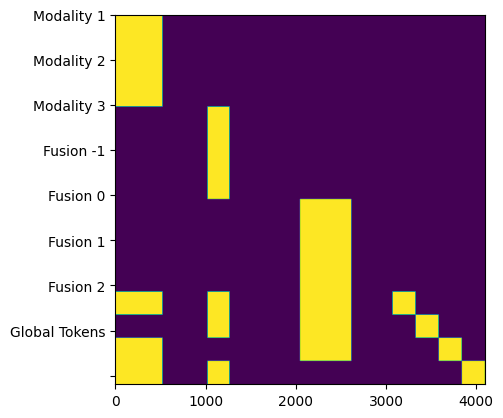

In [191]:
ax = plt.subplot(1,1,1)
im = ax.imshow(attn_mask[3,:,:] * zorro_mask)
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [72]:
torch.empty(0)

tensor([])

In [73]:
batch

{'expression_index': tensor([[  7,  10,  60,  ...,   0,   0,   0],
         [ 18,  49,  53,  ...,   0,   0,   0],
         [  3,  17,  26,  ...,   0,   0,   0],
         [ 60,  67, 136,  ...,   0,   0,   0]]),
 'spliced_index': tensor([[ 10,  60, 204,  ...,   0,   0,   0],
         [ 49, 134, 351,  ...,   0,   0,   0],
         [ 17,  46,  60,  ...,   0,   0,   0],
         [ 60, 183, 191,  ...,   0,   0,   0]]),
 'unspliced_index': tensor([[  7, 103, 238,  ...,   0,   0,   0],
         [ 18,  53, 120,  ...,   0,   0,   0],
         [ 26, 153, 198,  ...,   0,   0,   0],
         [136, 160, 332,  ...,   0,   0,   0]]),
 'expression_data': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 'spliced_data': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 2., 1.,  ..., 0., 0., 0.]]),
 'unspl

In [193]:
return_token_types = (0,1,2,3,3,3,3,4)
return_token_types_tensor = torch.tensor(list(return_token_types))
max_return_tokens = len(return_token_types)
dim=512
return_tokens = torch.nn.Parameter(torch.randn(max_return_tokens, dim))
return_tokens = repeat(return_tokens, 'n d -> b n d', b=4)

In [194]:
return_tokens.shape

torch.Size([4, 8, 512])

In [195]:
pool_mask = rearrange(return_token_types_tensor, 'i -> i 1') == token_types_attend_to
pool_mask = pool_mask | (rearrange(return_token_types_tensor, 'i -> i 1') == torch.ones_like(
            token_types_attend_to, dtype=torch.long) * 4)

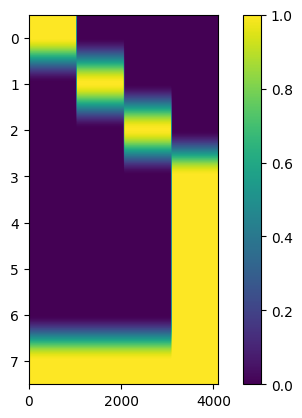

In [196]:
plt.imshow(pool_mask.to(torch.long), aspect=1000) #'auto')
plt.colorbar()

torch.Size([4096])
torch.Size([8, 4096])


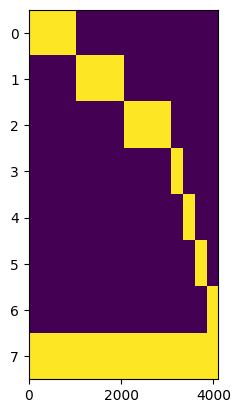

In [197]:
floom_pool_mask = torch.block_diag(torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)), 
                              torch.ones((1,256)))
print(token_types.shape)
select_mask = (return_token_types_tensor == 3).unsqueeze(1) *(token_types == 3).unsqueeze(0)
print(select_mask.shape)
pool_mask[select_mask] = floom_pool_mask.to(torch.bool).flatten()
#floom_mask = repeat(floom_mask, 'i j -> i j')
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask, aspect=1000, interpolation='none')

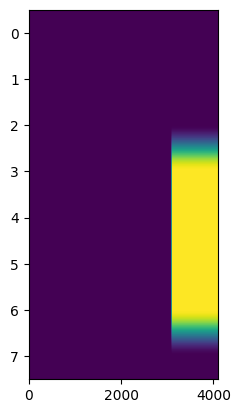

In [170]:
plt.imshow((return_token_types_tensor == 3).unsqueeze(1) *
           (token_types == 3).unsqueeze(0), aspect =1000)

ValueError: only one element tensors can be converted to Python scalars

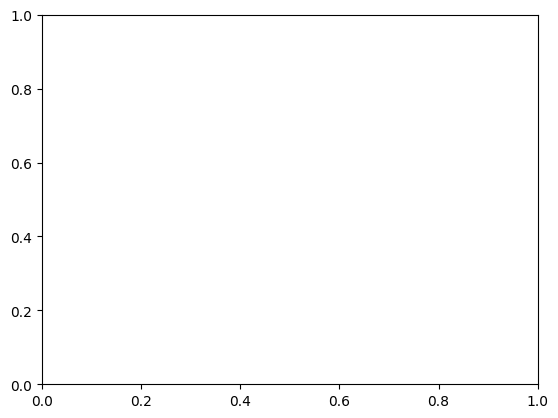

In [179]:
plt.plot(pool_mask.T)

torch.Size([4, 8, 4096])


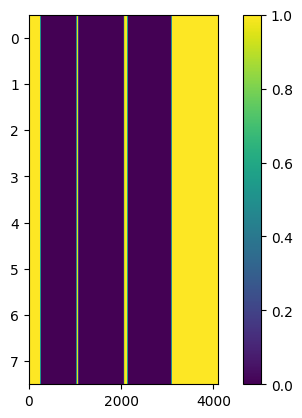

In [180]:
padding_mask = repeat(padding, 'b j -> b i j', i=pool_mask.shape[0])
print(padding_mask.shape)
plt.imshow(padding_mask[0,:,:].squeeze(), aspect=1000)
plt.colorbar()

/tmp/ipykernel_914643/1809391518.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


[Text(0, -1.0, '0'),
 Text(0, 0.0, 'Modality 1'),
 Text(0, 1.0, 'Modality 2'),
 Text(0, 2.0, 'Modality 3'),
 Text(0, 3.0, 'Fusion -1'),
 Text(0, 4.0, 'Fusion 0'),
 Text(0, 5.0, 'Fusion 1'),
 Text(0, 6.0, 'Fusion 2'),
 Text(0, 7.0, 'Global Tokens'),
 Text(0, 8.0, '')]

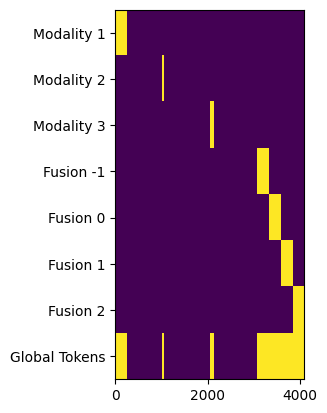

In [198]:
pool_mask = pool_mask * padding_mask
ax = plt.subplot(1,1,1)
im = ax.imshow(pool_mask[0], aspect=1000, interpolation='none')
#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['0','Modality 1','Modality 2','Modality 3','Fusion -1', 'Fusion 0', 'Fusion 1', 'Fusion 2','Global Tokens']
ax.set_yticklabels(labels)

In [160]:
q=torch.tensor([[1,2],
                [1,1]])
k=torch.tensor([[1,1],
                [2,1]])
v=q

In [163]:
from torch import einsum
sim = einsum('i d, d j -> i j', q, k) #Standard mm multipy
sim = einsum('i d, j d -> i j', q, k) #mm multiply with k transpose
print(sim)
#sim = sim.masked_fill(~attn_mask, -torch.finfo(sim.dtype).max)
#attn = sim.softmax(dim=-1)
attn = sim
out = einsum('i j, j d -> i d', attn, v) #standard multiply with no tranpose
print(out)
### SO COLUMNS SHOULD BE -inf for the mask!

tensor([[3, 4],
        [2, 3]])
tensor([[ 7, 10],
        [ 5,  7]])


In [156]:
sim

tensor([[2, 0],
        [0, 2]])

# Combine datasets

In [85]:
from datasets import concatenate_datasets, load_from_disk
import os
os.environ['HF_DATASETS_CACHE']='/shared/.cache/hugginface/dataset'
datasets = [
   'ad98d3cd-26fb-4ee3-99c9-8a2ab085e737_combined_all',
    'fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all',
    'cc95ff89-2e68-4a08-a234-480eca21ce79_combined_all',
    'fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all'
]
root = '/shared/'
loaded_datasets=[]
for dataset in datasets:
    loaded_datasets.append(load_from_disk(os.path.join(root,dataset)))
all_datasets=concatenate_datasets(loaded_datasets)

In [88]:
shuffled_dataset = all_datasets.shuffle(seed=42)

In [89]:
len(shuffled_dataset)

2630923

In [91]:
shuffled_dataset.save_to_disk(os.path.join(root,'dataset3M'))

In [29]:
import torch

In [37]:
t = torch.zeros(10)

In [38]:
t[torch.tensor([0,4,9])]=torch.tensor([1,2,3], dtype=torch.float)

In [39]:
t

tensor([1., 0., 0., 0., 2., 0., 0., 0., 0., 3.])

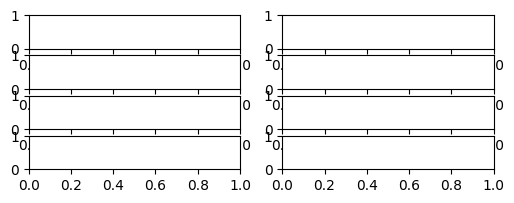

In [109]:
    f, ax= plt.subplots(4,2, figsize=(6,2))


In [110]:
ax

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

In [164]:
import datasets
!ls /shared
dataset = datasets.load_from_disk('/shared/how2_all_proc')

ad98d3cd-26fb-4ee3-99c9-8a2ab085e737_combined_all
cc95ff89-2e68-4a08-a234-480eca21ce79_combined_all
cell_chem_nci60_split
cell_chem_nci60_split.tar.gz
cell_chem_nci60_split.tar.gz.CDF5Cb6F
dataset3M
dataset3Mfiltered
fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all
fcaa53cd-ba57-4bfe-af9c-eaa958f95c1a_combined_all_veloc_sparse
fde199d2-a841-4ed1-aa65-b9e0af8969b1_combined_all
genecorpus_30M_10p_2048.dataset
genecorpus_30M_1p_2048.dataset
genecorpus_30M_2048.dataset
how2_all.dataset
how2_all_proc
lost+found
miniconda3
neuron_cache
tmp
val_preds_epoch_73.csv


In [169]:
dataset[0]['vid']

{'indices': tensor([   0,    1,    2,  ..., 2045, 2046, 2047]),
 'values': tensor([0.1111, 0.0778, 0.8021,  ..., 0.1853, 0.0574, 0.5909])}

In [ ]:
    #if plot_diag:
        """
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        plt.hist(diags.values(), bins=20)
        plt.legend(diags.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('Diag Cosine Similarity')
        plt.figure()
        plt.title("diagonals")
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')
        diags = {k:np.diagonal(mat) for k,mat in mat_dict.items()}
        diags_norm = {k:np.diagonal(mat)-np.mean(mat_dict[k]) for k, mat in mat_dict.items()}
        plt.hist(diags_norm.values(), bins=20)
        plt.legend(diags_norm.keys())
        plt.ylabel('Number of Batches')
        plt.xlabel('%Cosine Similarity Change from Mean of Diagonal')        
        """
        #plt.figure()
        #plt.title("")

In [60]:
x = torch.Tensor([[0,1,1,1],[0,1,1,0]])

In [62]:
torch.randperm(10)[:3]

tensor([7, 5, 3])

In [28]:
x.swapaxes(0,1)

tensor([[0., 0.],
        [1., 1.],
        [1., 1.],
        [1., 0.]])

In [100]:
x = [torch.Tensor([0.3]), torch.Tensor([1.3]), torch.Tensor([2.3]), torch.Tensor([np.nan])]

In [101]:
y = torch.cat(x)

In [102]:
z=~y.isnan()

In [108]:
w=torch.sum(z)

In [109]:
torch.sum(y[z])/w

tensor(1.3000)

In [105]:
z

tensor([ True,  True,  True, False])